##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

This tutorial demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`
1. Use an image classification model from TensorFlow Hub
1. Do simple transfer learning to fine-tune a model for your own image classes

## Setup

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

## An ImageNet classifier

You'll start by using a pretrained classifer model to take an image and predict what it's an image of - no training required!

### Download the classifier

Use `hub.KerasLayer` to load a [MobileNetV2 model](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) from TensorFlow Hub. Any [compatible image classifier model](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [4]:
classifier_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" #@param {type:"string"}

In [5]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on.

65536/61306 [================================] - 0s 0us/step


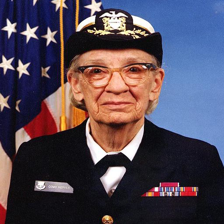

In [6]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [13]:
print(grace_hopper.shape)
print(grace_hopper[np.newaxis, ...].shape)

(224, 224, 3)
(1, 224, 224, 3)


In [14]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [15]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [22]:
top_predicted_classes = np.argsort(-result[0])[:5]

### Decode the predictions

Take the predicted class ID and fetch the `ImageNet` labels to decode the predictions

In [16]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


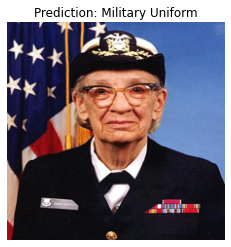

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

Top 5 values

In [23]:
imagenet_labels[top_predicted_classes]

array(['military uniform', 'bearskin', 'mortarboard', 'suit',
       'ballplayer'], dtype='<U30')

## Simple transfer learning

But what if you want to train a classifier for a dataset with different classes? You can also use a model from TFHub to train a custom image classier by retraining the top layer of the model to recognize the classes in our dataset.

### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [24]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

TensorFlow Hub's conventions for image models is to expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

In [25]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [26]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [27]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [28]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['bee', 'daisy', 'daisy', 'drum', 'pot', 'vase', 'daisy',
       'rapeseed', 'cardoon', 'daisy', 'daisy', 'bee', 'daisy', 'daisy',
       'handkerchief', 'bakery', 'cardoon', 'vase', 'bee',
       'American egret', 'banana', 'vase', 'ant', 'vase', 'coral fungus',
       'daisy', 'bald eagle', 'rapeseed', 'conch', 'quill', 'daisy',
       'barn spider'], dtype='<U30')

Now check how these predictions line up with the images:

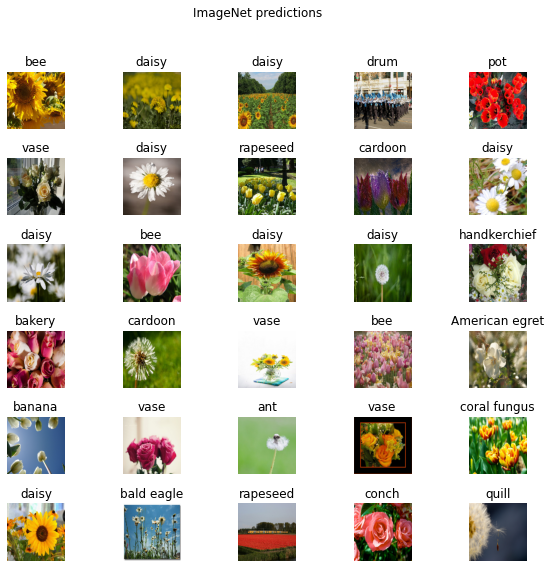

In [29]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [compatible image feature vector model](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [30]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

Create the feature extractor. Use `trainable=False` to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [31]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

It returns a 1280-length vector for each image:

In [32]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [33]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
predictions = model(image_batch)

In [35]:
predictions.shape

TensorShape([32, 5])

### Train the model

Use compile to configure the training process:

In [36]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [37]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [38]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 224s 2s/step - loss: 0.2790 - acc: 0.9062
Epoch 2/2
115/115 [==============================] - 227s 2s/step - loss: 0.3560 - acc: 0.8750


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

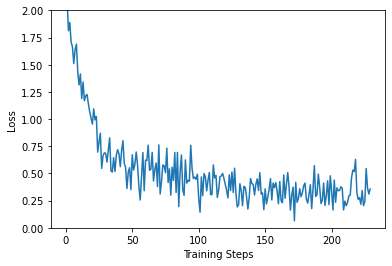

In [39]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

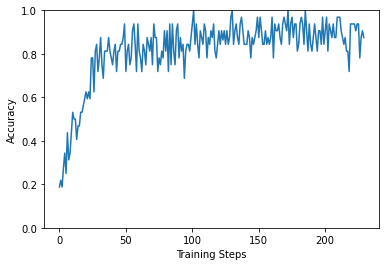

In [40]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [41]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and convert the indices to class names.

In [42]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [43]:
label_id = np.argmax(label_batch, axis=-1)

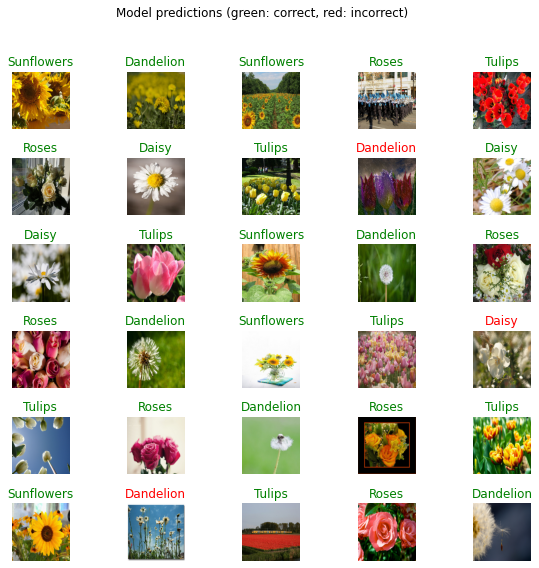

In [44]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export your model

Now that you've trained the model, export it as a SavedModel for use later on.

In [45]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_models/1602257107/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1602257107/assets


'/tmp/saved_models/1602257107'

Now confirm that we can reload it, and it still gives the same results:

In [46]:
reloaded = tf.keras.models.load_model(export_path)

In [47]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [48]:
abs(reloaded_result_batch - result_batch).max()

0.0

This SavedModel can be loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).


## Learn more

Check out more [tutorials](https://www.tensorflow.org/hub/tutorials) for using image models from TensorFlow Hub.